In [35]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$

where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [36]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int

In [37]:
def SubG_update(composite_function, state):
    f, g, = composite_function
    x_k, k = state

    alpha_k = 0.1 / np.sqrt(k)
    next_x_k = x_k - alpha_k * (f.grad(x_k) + g.subgrad(x_k))

    return SubG_state(x_k=next_x_k, k=k+1)

def SubG_initialize(composite_function, x_zero):
    return SubG_state(x_k=x_zero, k=1)

In [38]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

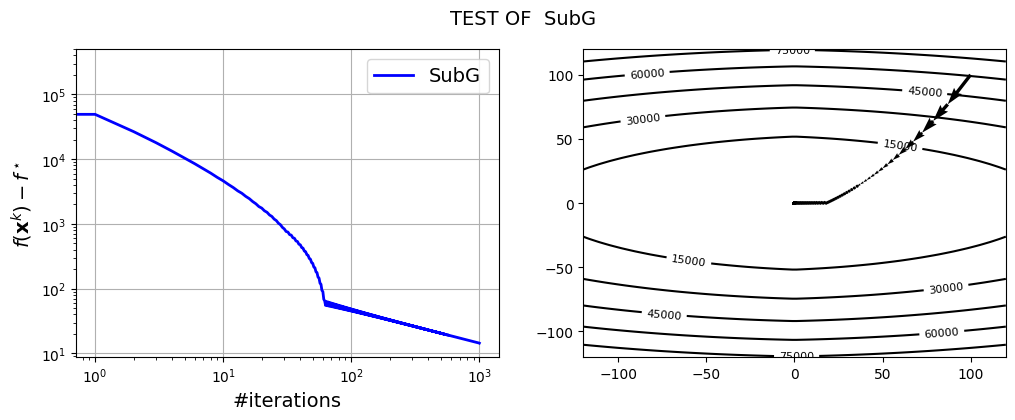

In [39]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


$$
\text{prox}_{\gamma \| \cdot \|_1}(z) = \arg \min_{y} \left\{ \gamma \|y\|_1 + \frac{1}{2} \|y - z\|_2^2 \right\}
$$

The function we are minimizing can be expressed in scalar form as:

$$
\gamma \sum_{i=1}^p |y_i| + \frac{1}{2} \sum_{i=1}^p (y_i - z_i)^2
$$

So for each $i$:

$$
\gamma |y_i| + \frac{1}{2} (y_i - z_i)^2
$$

piecewise function

$$
\gamma y_i + \frac{1}{2} (y_i - z_i)^2, \quad \text{with} \quad y_i \geq 0.
\frac{d}{dy_i} \left( \gamma y_i + \frac{1}{2} (y_i - z_i)^2 \right) = \gamma + (y_i - z_i) = 0.
y_i = \max(z_i - \gamma, 0).
$$

$$
\gamma (-y_i) + \frac{1}{2} (y_i - z_i)^2, \quad \text{with} \quad y_i \leq 0.
-\gamma + (y_i - z_i) = 0 \quad \Rightarrow \quad y_i = z_i + \gamma.
y_i = \min(z_i + \gamma, 0).
$$

This can be generalized to:

$$
y_i = \text{sign}(z_i) \max(|z_i| - \gamma, 0)
$$

...

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [40]:
def l1_prox(gamma, z):
    return np.maximum(0, np.abs(z) - gamma) * np.sign(z)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method $\text{ISTA}_{\mu}$.

In [41]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha: float

In [42]:
def ISTA_update(composite_function, state):
    f, g = composite_function
    x_k, alpha = state.x_k, state.alpha
    
    next_x_k = l1_prox(alpha, x_k - alpha * f.grad(x_k))

    return ISTA_state(x_k=next_x_k, alpha=alpha)

def ISTA_initialize(composite_function, x_zero):
    f = composite_function.f
    alpha = 2 / (f.lips_grad + f.strng_cvx)
    return ISTA_state(x_k=x_zero, alpha=alpha)

In [43]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

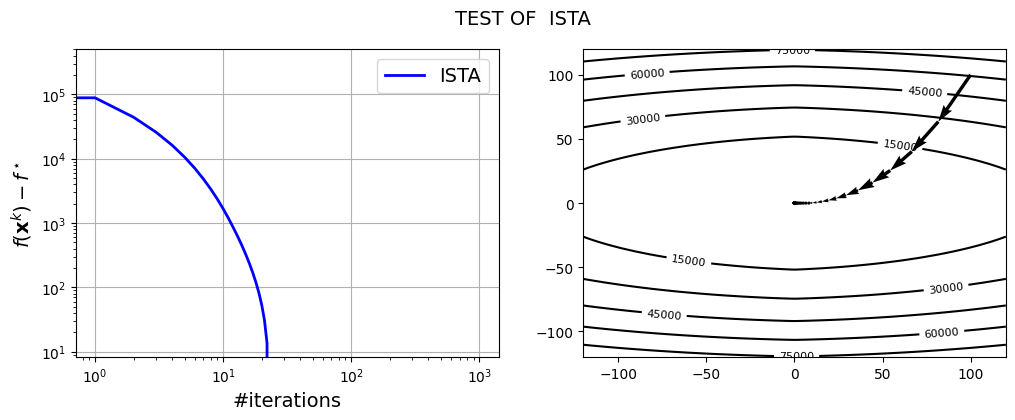

In [44]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method $\text{FISTA}_{\mu}$.

In [45]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha: float
    c_frac: float

In [46]:
import numpy

def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k, y_k, alpha, c_frac = state.x_k, state.y_k, state.alpha, state.c_frac

    next_x_k = l1_prox(alpha, y_k - alpha * f.grad(y_k))
    next_y_k = next_x_k + c_frac * (next_x_k - x_k)

    return FISTA_state(x_k=next_x_k, y_k=next_y_k, alpha=alpha, c_frac=c_frac)

def FISTA_initialize(composite_function, x_zero):
    f = composite_function.f
    alpha = 1 / f.lips_grad
    c = f.lips_grad / f.strng_cvx
    c_frac = (np.sqrt(c) - 1) / (np.sqrt(c) + 1)
    return FISTA_state(x_k=x_zero, y_k=x_zero, alpha=alpha, c_frac=c_frac)

In [47]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

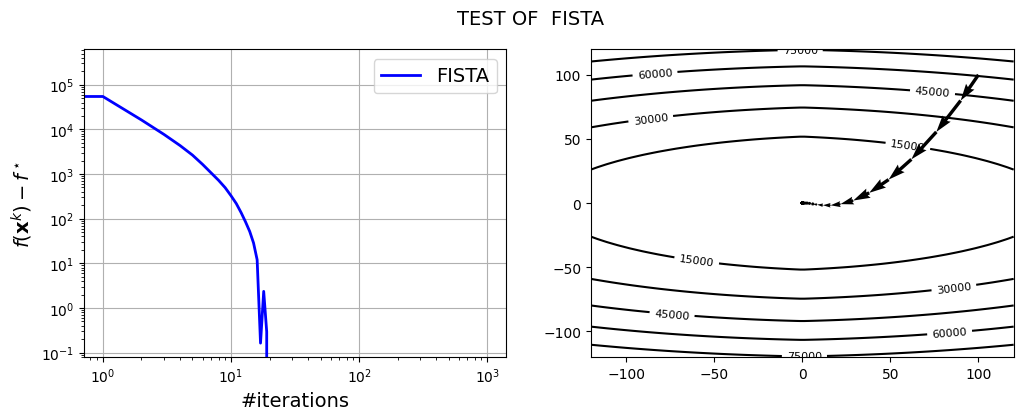

In [48]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

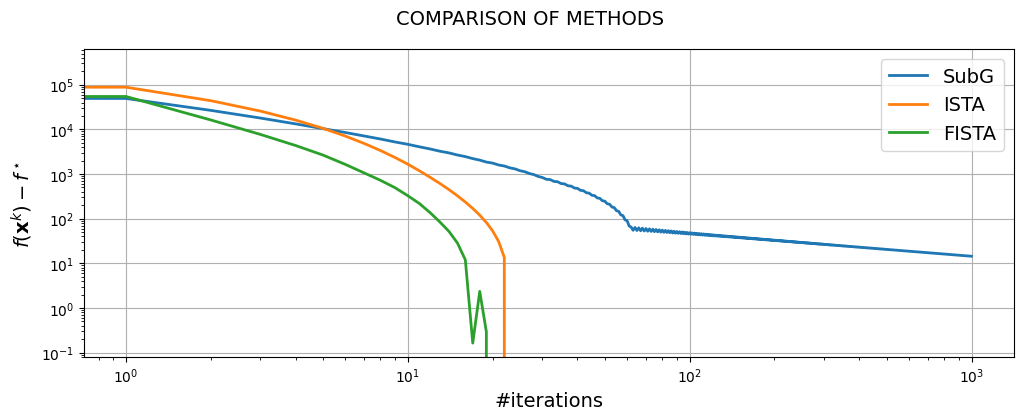

In [49]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

**Solution:**

The subgradient method is the slowest of the three, which is expected and aligns with its sublinear convergence.
Both ISTA and FISTA show linear convergence rate, with FISTA converging faster than ISTA. 

- **Subgradient Method (SubG)**: $ O\left(\frac{1}{\sqrt{k}}\right) $
- **ISTA**: $ O\left(\frac{1}{k}\right) $
- **FISTA**: $ O\left(\frac{1}{k^2}\right) $

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

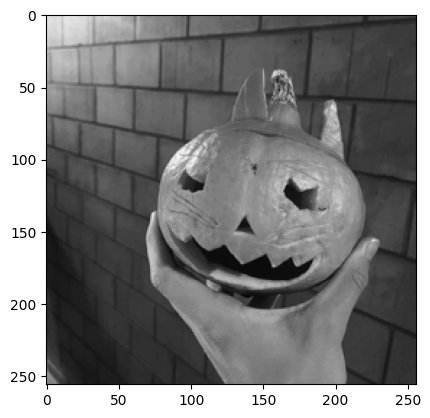

In [50]:
from lib.inpainting import *

image = load("lib/pumpkin.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

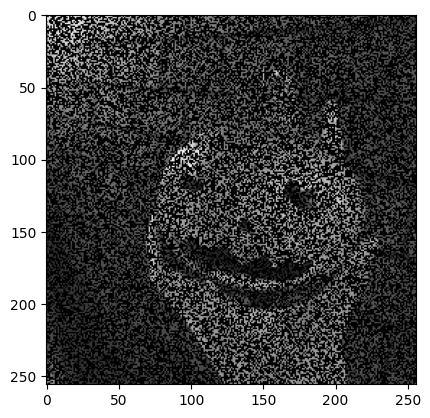

In [51]:
subsampled = show_subsampled(image)

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [52]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [53]:
mu = 1e-4 # Desired strong convexity of f
def f_l1(alpha):
    return 1 / 2 * np.linalg.norm(b - P(W_T(alpha))) ** 2

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [54]:
def grad_f_l1(alpha):
    return W(P_T(P(W_T(alpha)) - b))

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

**Solution:**

$$
\| \nabla f(x) - \nabla f(y) \|_2 \leq L \| x - y \|_2
$$

$$
\frac{\| \nabla f(x) - \nabla f(y) \|_2}{\| x - y \|_2} \leq L
$$

$$
\| \nabla^2 f(x) \|_2 \leq L
$$

$$
L = \lambda_{\max}(\mathbf{W} \mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega} \mathbf{W}^\top)
$$

Recall that $\mathbf{W}$ is an orthogonal basis matrix and $\mathbf{P}_{\Omega}$ is projectional matrix. This means that, $\mathbf{P}_{\Omega}^2=\mathbf{P}_{\Omega}$.

Since $\mathbf{W}$ is orthonormal $(\mathbf{W}^\top \mathbf{W} = \mathbf{I} )$, $\mathbf{W}$ essentially "transforms" the matrix $\mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega}$ into the coordinate system defined by $ \mathbf{W} $. 
Therefore, $\mathbf{W}^\top\mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega}\mathbf{W}$ will have the same eigenvalues as $\mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega}$, because orthonormal transformations preserve the spectral norm.

Since $\mathbf{P}_{\Omega}$ is a projection matrix, its eigenvalues are either $0$ or $1$. Therefore, the spectral norm $||\mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega}||$, and consequently $||\mathbf{W} \mathbf{P}_{\Omega} ^\top \mathbf{P}_{\Omega} \mathbf{W}^\top||$ equals $1$.

In [55]:
lips_grad_f_l1 = 1

We have all the necessary ingredients to define the smooth part of our composite objective:

In [56]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [57]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [58]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [59]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

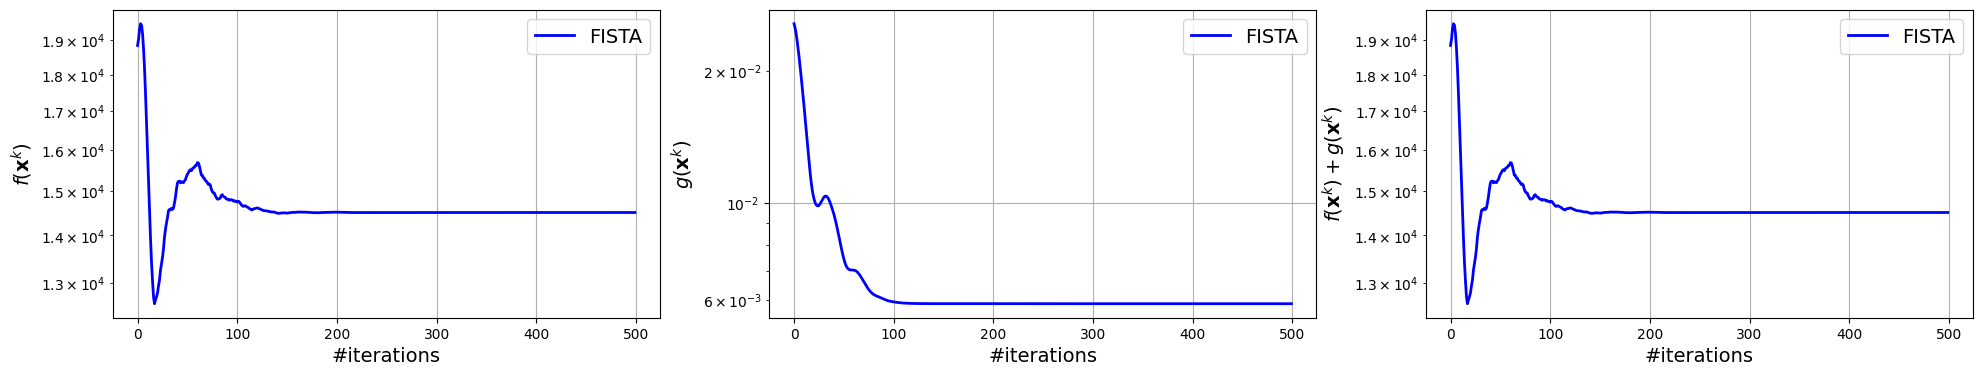

In [60]:
output = solve_composite(FISTA, composite_objective, 1e-8, 500)
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)

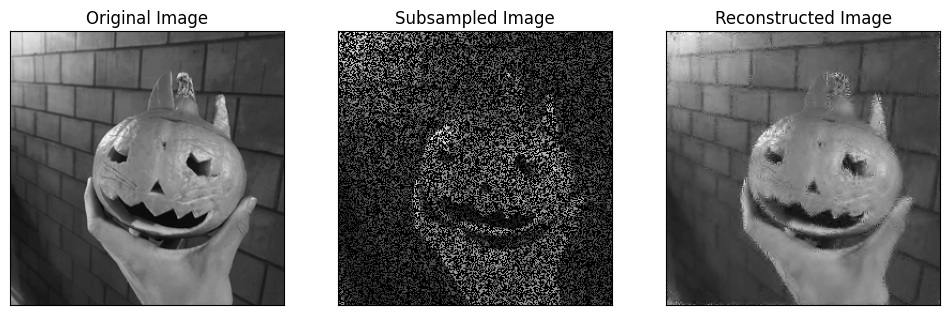

In [61]:
show(true = image, subsampled=subsampled, estimated=image_out)

In [62]:
def PSNR(original, reconstructed): 
    assert original.shape == reconstructed.shape
    mse = np.mean((original - reconstructed) ** 2) 
    if(mse == 0):  
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [63]:
def l1_prox(gamma, z, lambda_):
    return lambda_ * np.sign(z) * np.maximum(np.abs(z) - gamma, 0)

@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    y_k: Vector
    alpha: float
    lr: float
    lambda_: float

def FISTA_update(composite_function, state):
    f, g = composite_function
    x_k, y_k, alpha, lr, lambda_ = state.x_k, state.y_k, state.alpha, state.lr, state.lambda_
    x_next_k = l1_prox(alpha, y_k - alpha * f.grad(y_k), lambda_)
    y_next_k = x_next_k + lr * (x_next_k - x_k)
    
    return FISTA_state(x_k=x_next_k, y_k=y_next_k, alpha=alpha, lr=lr, lambda_=lambda_)

Lambda: 0.99, PSNR: 14.996609604164954
Lambda: 0.999, PSNR: 28.606961748953346
Lambda: 0.9999, PSNR: 29.636794616676163
Lambda: 0.99999, PSNR: 29.707603165085075
Lambda: 1, PSNR: 29.715242405068164
Lambda: 1.0001, PSNR: 29.778783880931844
Lambda: 1.001, PSNR: 29.776269289503926
Lambda: 1.01, PSNR: -386.24466016006244
Best lambda: 1.0001


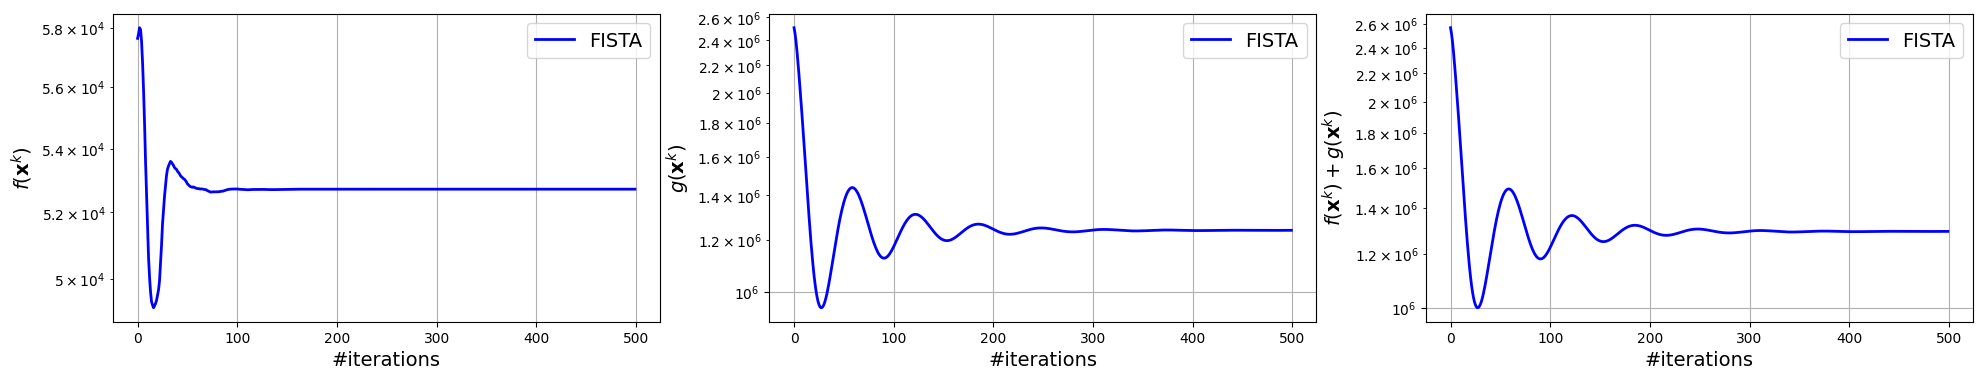

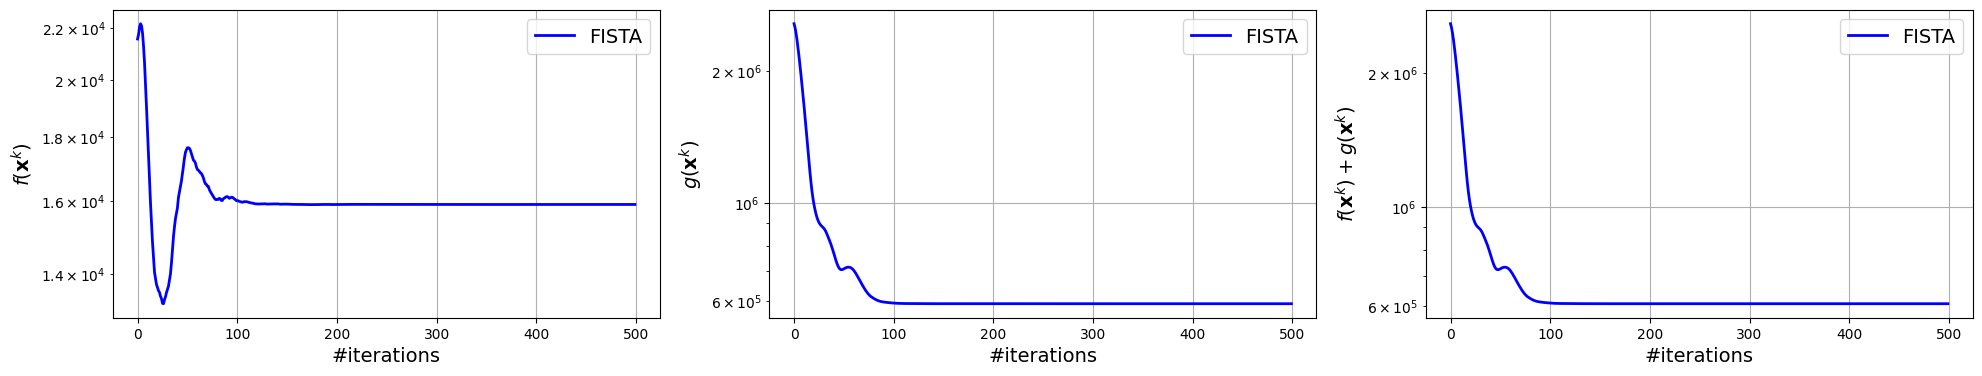

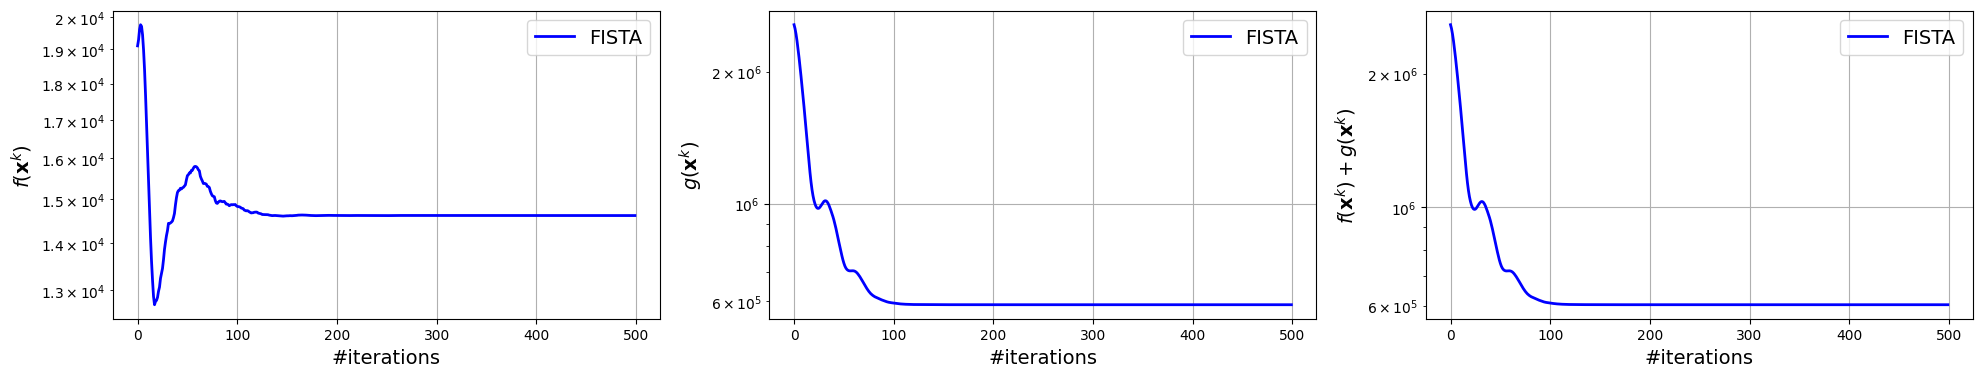

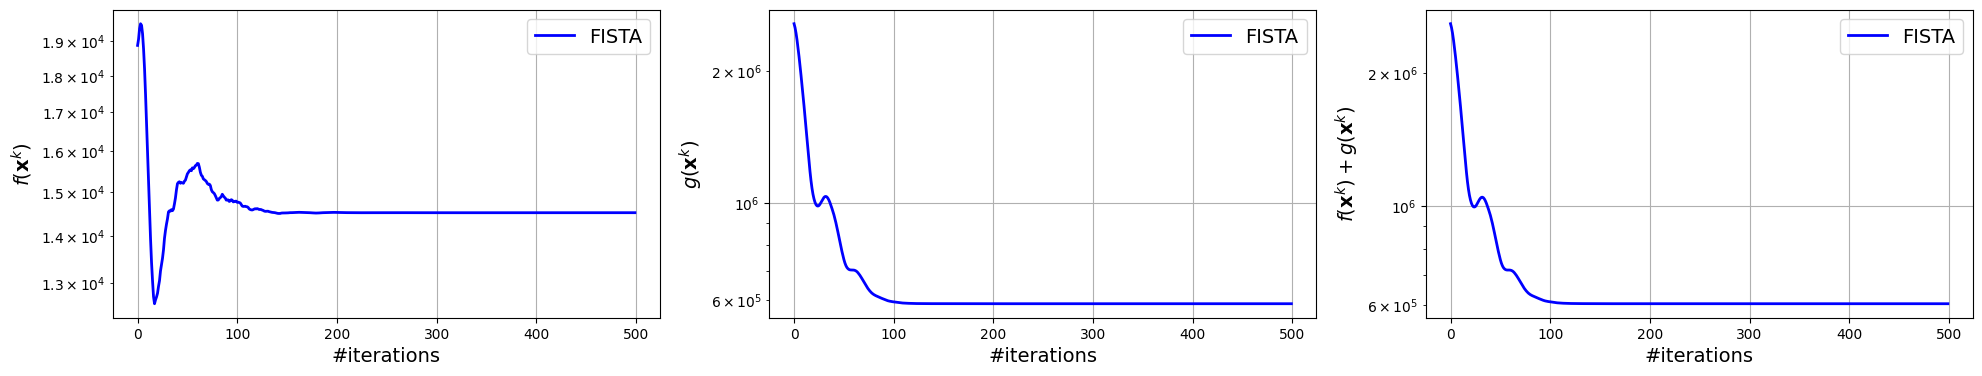

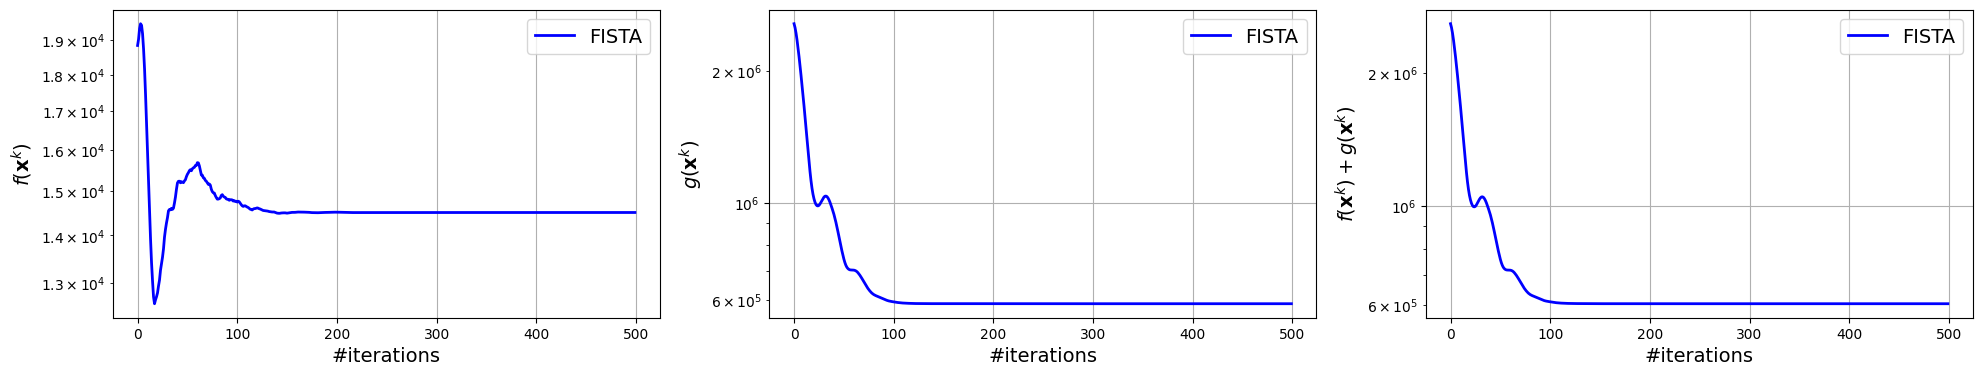

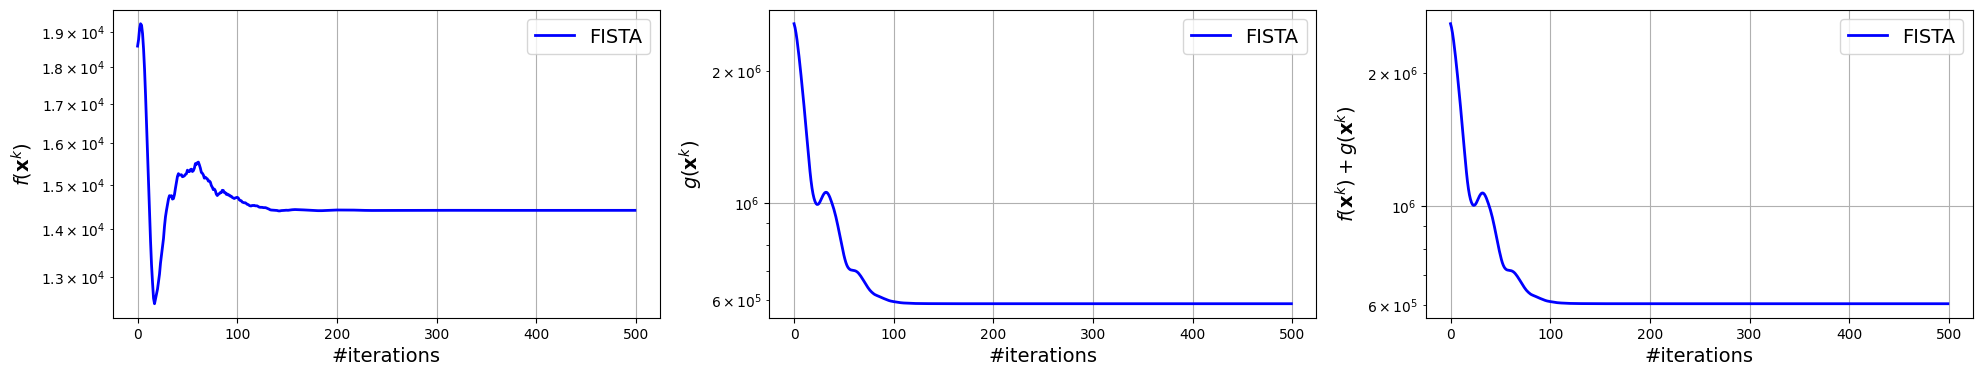

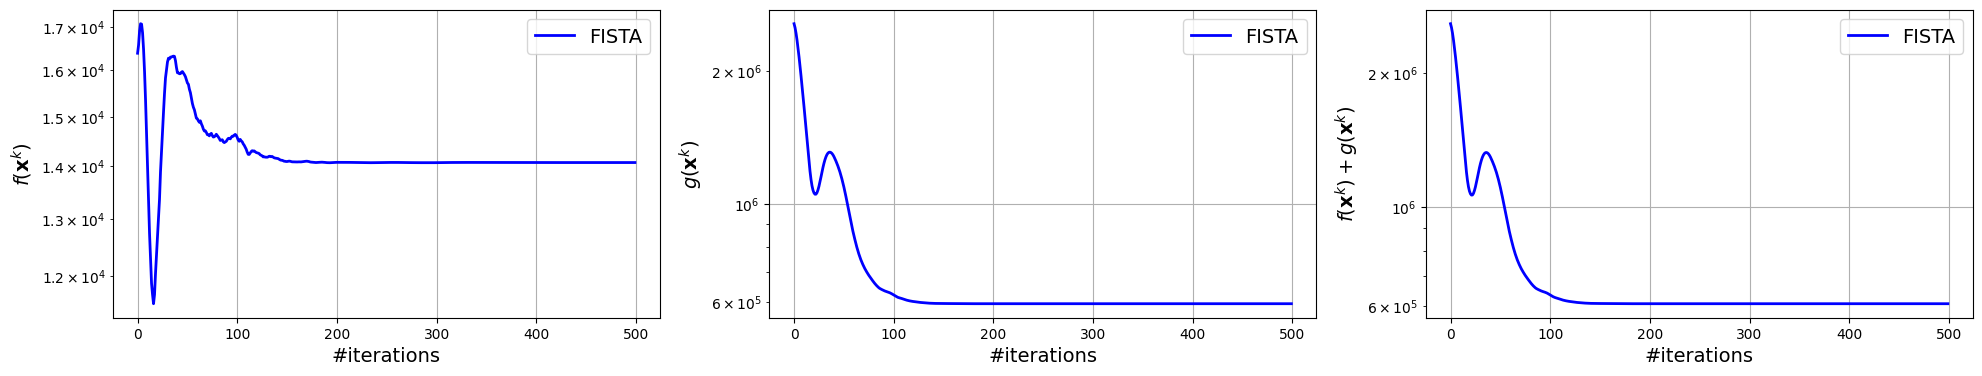

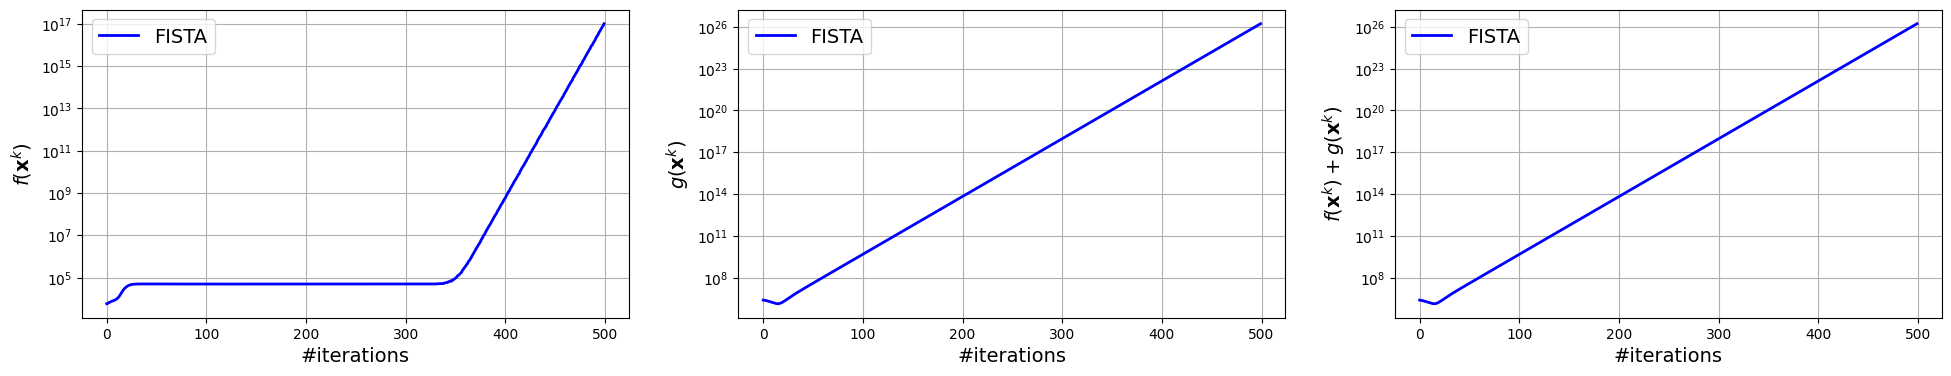

In [64]:
lambdas = [0.99, 0.999, 0.9999, 0.99999, 1, 1.0001, 1.001, 1.01]
psnrs = []

for l in lambdas:
    def FISTA_initialize(composite_function, x_zero):
        f, g = composite_function
        c_f = f.lips_grad/f.strng_cvx
        lr = (np.sqrt(c_f) - 1)/(np.sqrt(c_f) + 1)
        alpha = 1/f.lips_grad
        return FISTA_state(x_k=x_zero, y_k=x_zero, alpha=alpha, lr = lr, lambda_=l)

    FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)
    
    output = solve_composite(FISTA, composite_objective, l, 500)
    reconstructed = W_T(output).reshape(image.shape)
    psnr_score = PSNR(image, reconstructed)
    print(f'Lambda: {l}, PSNR: {psnr_score}')
    psnrs.append(psnr_score)

best_lambda = lambdas[np.argmax(psnrs)]
print('Best lambda:', best_lambda)

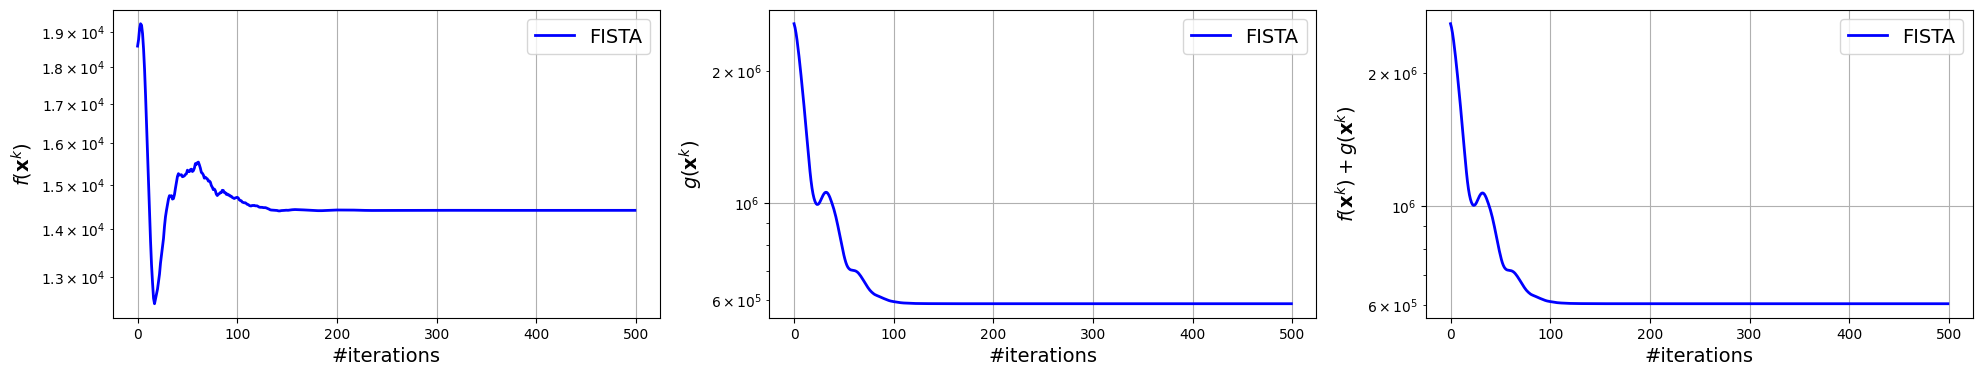

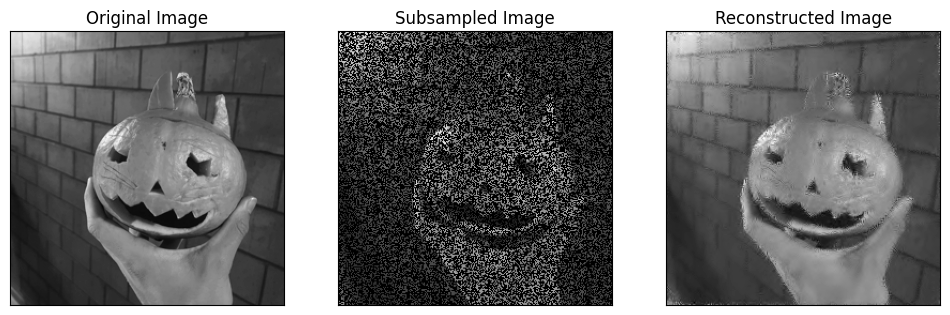

In [67]:
l = best_lambda
def FISTA_initialize(composite_function, x_zero):
    f, g = composite_function
    c_f = f.lips_grad/f.strng_cvx
    lr = (np.sqrt(c_f) - 1)/(np.sqrt(c_f) + 1)
    alpha = 1/f.lips_grad
    return FISTA_state(x_k=x_zero, y_k=x_zero, alpha=alpha, lr = lr, lambda_=l)

FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

output = solve_composite(FISTA, composite_objective, l, 500)

flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)
show(true = image, subsampled=subsampled, estimated=image_out)